# Dataset Description

In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

# File Descriptions and Data Field Information 


## train.csv

- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

## test.csv

- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

## sample_submission.csv

- A sample submission file in the correct format.

## stores.csv

- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

## oil.csv

- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

## holidays_events.csv

- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

## Additional Notes

- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Importing the Datasets

Read in the csv files into dataframes

In [2]:
train = pd.read_csv("store_sales_time_series_forecasting_train.csv")

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train.shape

(3000888, 6)

In [5]:
test = pd.read_csv("store_sales_time_series_forecasting_test.csv")

In [6]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [7]:
transactions  = pd.read_csv("transactions.csv")

In [8]:
transactions.head() 

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
stores = pd.read_csv("stores.csv")

In [10]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
holidays_events = pd.read_csv("holidays_events.csv")

In [12]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [13]:
oil = pd.read_csv("oil.csv")

In [14]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


 As there are no daily oil prices from on those dates I have decided to discard the oil data.

# Data Preprocessing

Identify missing values in the dataframes.

In [15]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [16]:
test.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [17]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [18]:
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [19]:
holidays_events.isnull().sum() 

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [20]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [21]:
oil.shape

(1218, 2)

Join dataframes

In [22]:
train_stores = pd.merge(train, stores, on=['store_nbr'], how='left')

In [23]:
train_stores.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [24]:
train_stores.shape

(3000888, 10)

In [25]:
train_stores_holidays = pd.merge(train_stores, holidays_events, on=['date'], how='left')

In [26]:
train_stores_holidays.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [27]:
train_stores_holidays.shape

(3054348, 15)

I notice that the number of rows has jumped from 3000888 to 3054348. This needs to be investigated.


Multiple Matches in holidays_events DataFrame: If there are multiple rows in the holidays_events DataFrame that have the same date as a single row in the train_stores DataFrame, each of these holidays_events rows will be merged with the corresponding train_stores row, leading to multiple rows in the output for that date.

Duplicated Dates in train_stores DataFrame: Similarly, if there are duplicated dates within the train_stores DataFrame itself, and holidays_events has matching dates, each of these duplicates will be merged with the corresponding rows in holidays_events, potentially increasing the number of rows more than expected.

Should the rows which are holidays be removed ? This needs to be tested to see if the store is closed on those days.

In [28]:
#Create a dataframe that only has rows that are holidays

holiday_df = train_stores_holidays.query("type_y in ('Holiday', 'Additional', 'Event', 'Transfer', 'Bridge') & transferred == False ")

In [29]:
holiday_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [30]:
holiday_df.query("sales > 0")

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
563,563,2013-01-01,25,BEAUTY,2.000,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
564,564,2013-01-01,25,BEVERAGES,810.000,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
566,566,2013-01-01,25,BREAD/BAKERY,180.589,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
568,568,2013-01-01,25,CLEANING,186.000,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
569,569,2013-01-01,25,DAIRY,143.000,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False


We can see from above that there is 335016 rows with sales > 0. Which would indicate that the stores are open on holdays.

Check to see if store activity is normal on January 1st

In [31]:
holiday_df.query("date in ('2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01') & sales > 0")

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
563,563,2013-01-01,25,BEAUTY,2.000,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
564,564,2013-01-01,25,BEVERAGES,810.000,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
566,566,2013-01-01,25,BREAD/BAKERY,180.589,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
568,568,2013-01-01,25,CLEANING,186.000,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
569,569,2013-01-01,25,DAIRY,143.000,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973262,1946532,2016-01-01,25,PLAYERS AND ELECTRONICS,10.000,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
1973263,1946533,2016-01-01,25,POULTRY,261.179,27,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
1973264,1946534,2016-01-01,25,PREPARED FOODS,94.699,1,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
1973265,1946535,2016-01-01,25,PRODUCE,2384.509,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False


From the above we can see that only stores 25 and 36 have made sales on the 1/1. All other stores have 0 sales on that day.

I have decided to remove all rows that occur on 1/1.

In [32]:
train_stores_holidays['date'].max()


'2017-08-15'

In [33]:
train_stores_holidays['date'].min()

'2013-01-01'

In [34]:
train_stores_holidays.query("date in ('2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01')")

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644483,2598151,2017-01-01,9,POULTRY,0.0,0,Quito,Pichincha,B,6,Holiday,National,Ecuador,Primer dia del ano,True
2644484,2598152,2017-01-01,9,PREPARED FOODS,0.0,0,Quito,Pichincha,B,6,Holiday,National,Ecuador,Primer dia del ano,True
2644485,2598153,2017-01-01,9,PRODUCE,0.0,0,Quito,Pichincha,B,6,Holiday,National,Ecuador,Primer dia del ano,True
2644486,2598154,2017-01-01,9,SCHOOL AND OFFICE SUPPLIES,0.0,0,Quito,Pichincha,B,6,Holiday,National,Ecuador,Primer dia del ano,True


In [35]:
pd.options.display.max_rows = 400

In [36]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [37]:
test['date'].max()

'2017-08-31'

In [38]:
test['date'].min()

'2017-08-16'

The above code shows that the dates in test are after those in train. As there are no daily oil prices from on those dates I have decided to discard the oil data. There is no information relating to transactions . So that data will also be discarded.

In [39]:
transactions['date'].max()

'2017-08-15'

In [40]:
train_stores_holidays.shape

(3054348, 15)

In [41]:
train.shape

(3000888, 6)

Identify rows in merged_df that are not in the original train.

In [42]:
train_stores.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster'],
      dtype='object')

In [43]:
train_stores_holidays.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'type_y', 'locale', 'locale_name',
       'description', 'transferred'],
      dtype='object')

From above we can see that the increase in rows is being caused by the 'type' column. Both train and holidays_events have a 'type' column but they contain different information . train['type'] refers to the type of store, whilst holidays_events['type'] refers to the type of event. 

To avoid this duplication I will rename the 'type' column in holidays_events to 'event' before merging.

In [44]:
holidays_events = holidays_events.rename(columns={'type': 'event'})

In [45]:
merged_df = pd.merge(train_stores, holidays_events, on=['date'], how='left')

In [46]:
merged_df.shape 

(3054348, 15)

In [47]:
merged_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'event', 'locale', 'locale_name',
       'description', 'transferred'],
      dtype='object')

In [48]:
holidays_events 

,date,event,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [49]:
merged_df.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,event,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


Multiple Matches in holidays_events DataFrame: If there are multiple rows in the holidays_events DataFrame that have the same date as a single row in the train_stores DataFrame, each of these holidays_events rows will be merged with the corresponding train_stores row, leading to multiple rows in the output for that date.


In [50]:

value_counts = holidays_events['date'].value_counts()
holidays_events[holidays_events['date'].isin(value_counts[value_counts == 4].index)]


,date,event,locale,locale_name,description,transferred
110,2014-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
111,2014-06-25,Holiday,Local,Machala,Fundacion de Machala,False
112,2014-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False


In [51]:
merged_df[merged_df['date']=='2014-06-25']

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,event,locale,locale_name,description,transferred
969408,960498,2014-06-25,1,AUTOMOTIVE,1.000,0,Quito,Pichincha,D,13,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
969409,960498,2014-06-25,1,AUTOMOTIVE,1.000,0,Quito,Pichincha,D,13,Holiday,Local,Machala,Fundacion de Machala,False
969410,960498,2014-06-25,1,AUTOMOTIVE,1.000,0,Quito,Pichincha,D,13,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
969411,960498,2014-06-25,1,AUTOMOTIVE,1.000,0,Quito,Pichincha,D,13,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False
969412,960499,2014-06-25,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976531,962278,2014-06-25,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,Quito,Pichincha,B,6,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False
976532,962279,2014-06-25,9,SEAFOOD,17.341,0,Quito,Pichincha,B,6,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
976533,962279,2014-06-25,9,SEAFOOD,17.341,0,Quito,Pichincha,B,6,Holiday,Local,Machala,Fundacion de Machala,False
976534,962279,2014-06-25,9,SEAFOOD,17.341,0,Quito,Pichincha,B,6,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False


In [52]:
train[train['date']=='2014-06-25']

,id,date,store_nbr,family,sales,onpromotion
960498,960498,2014-06-25,1,AUTOMOTIVE,1.000,0
960499,960499,2014-06-25,1,BABY CARE,0.000,0
960500,960500,2014-06-25,1,BEAUTY,0.000,0
960501,960501,2014-06-25,1,BEVERAGES,1202.000,0
960502,960502,2014-06-25,1,BOOKS,0.000,0
...,...,...,...,...,...,...
962275,962275,2014-06-25,9,POULTRY,360.695,0
962276,962276,2014-06-25,9,PREPARED FOODS,42.347,0
962277,962277,2014-06-25,9,PRODUCE,0.000,0
962278,962278,2014-06-25,9,SCHOOL AND OFFICE SUPPLIES,0.000,0


As joining the holidays_events dataframe introduces a lot of duplication . I have decided to keep the join but only add the 'event' column.

In [53]:
holidays_events['description'].value_counts()

Carnaval                                           10
Fundacion de Ibarra                                 7
Fundacion de Cuenca                                 7
Cantonizacion de Cayambe                            6
Independencia de Ambato                             6
Fundacion de Riobamba                               6
Cantonizacion de Riobamba                           6
Fundacion de Machala                                6
Cantonizacion del Puyo                              6
Provincializacion Santa Elena                       6
Dia de Difuntos                                     6
Fundacion de Loja                                   6
Independencia de Guaranda                           6
Cantonizacion de Latacunga                          6
Cantonizacion de Quevedo                            6
Independencia de Cuenca                             6
Fundacion de Quito-1                                6
Cantonizacion de Libertad                           6
Navidad-1                   

In [54]:
value_counts = holidays_events['date'].value_counts()
holidays_events[holidays_events['date'].isin(value_counts[value_counts > 1].index)]

,date,event,locale,locale_name,description,transferred
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False
10,2012-07-03,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False
11,2012-07-03,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False
32,2012-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False


From the above we can see that the 'transferred' column values are all 'False' so the join is straight forward.

In [55]:
train_stores.shape

(3000888, 10)

In [56]:
train_stores['event'] = train_stores.merge(holidays_events[['date', 'event']], on='date', how='left')['event']

In [57]:
train_stores.shape

(3000888, 11)

The number of rows is correct.

In [58]:
train_stores.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,event
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday


I have decided to remove all rows that occur on 1/1 as vast majority of stores have 0 sales on this day.

In [59]:
train_stores['date'].min()

'2013-01-01'

In [60]:
train_stores['date'].max()

'2017-08-15'

In [61]:
excluded_dates = ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01']
train_stores_filtered_df = train_stores[~train_stores['date'].isin(excluded_dates)]


In [62]:
train_stores_filtered_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,event
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,NaN
1783,1783,2013-01-02,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
1784,1784,2013-01-02,1,BEAUTY,2.0,0,Quito,Pichincha,D,13,NaN
1785,1785,2013-01-02,1,BEVERAGES,1091.0,0,Quito,Pichincha,D,13,NaN
1786,1786,2013-01-02,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


In [63]:
train_stores_filtered_df['date'].min()

'2013-01-02'

In [64]:
train_stores_filtered_df['date'].max()

'2017-08-15'

In [65]:
train_stores_filtered_df.shape

(2991978, 11)

In [66]:
train_stores_filtered_df.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
event          2507274
dtype: int64

Identify the unique values in the 'event' column

In [67]:
train_stores_filtered_df['event'].value_counts()

Holiday       293139
Event          99792
Additional     63261
Transfer       14256
Work Day        8910
Bridge          5346
Name: event, dtype: int64

In [68]:
2991978 - train_stores_filtered_df['event'].value_counts().sum()

2507274

Replace null values in 'event' column with 'Normal Day'

In [69]:
df_temp = train_stores_filtered_df.copy()  # Create a copy of the DataFrame
df_temp['event'].fillna('Normal Day', inplace=True)
train_stores_filtered_df = df_temp  # Optional: If you want to overwrite the original 'df'

In [70]:
train_stores_filtered_df['event'].value_counts()

Normal Day    2507274
Holiday        293139
Event           99792
Additional      63261
Transfer        14256
Work Day         8910
Bridge           5346
Name: event, dtype: int64

Preparation of 'date' column. 


Consider Seasonality and Cyclic Features: For some datasets, the time of year is important. You might need to capture seasonality or cyclic nature of the data, such as knowing that December is close to January in terms of season but far apart numerically. One way to capture this is by using sine and cosine transformations for cyclic features like months or days.

 df['month_sin'] = np.sin((df['month']-1) * (2. * np.pi/12))
 df['month_cos'] = np.cos((df['month']-1) * (2. * np.pi/12))

Parse Dates: Ensure that the 'date' column is parsed into a datetime format if it isn't already. This can usually be done using pandas in Python with pd.to_datetime().

 

 

In [71]:
train_stores_filtered_df['date'] = pd.to_datetime(train_stores_filtered_df['date']) 
train_stores_filtered_df['year'] = train_stores_filtered_df['date'].dt.year 
train_stores_filtered_df['month'] = train_stores_filtered_df['date'].dt.month 
train_stores_filtered_df['day'] = train_stores_filtered_df['date'].dt.day 
train_stores_filtered_df['dayofweek'] = train_stores_filtered_df['date'].dt.dayofweek 
train_stores_filtered_df['is_weekend'] = train_stores_filtered_df['date'].dt.dayofweek >= 5

In [72]:
train_stores_filtered_df['month_sin'] = np.sin((train_stores_filtered_df['month']-1) * (2. * np.pi/12))
train_stores_filtered_df['month_cos'] = np.cos((train_stores_filtered_df['month']-1) * (2. * np.pi/12))

In [73]:
train_stores_filtered_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,event,year,month,day,dayofweek,is_weekend,month_sin,month_cos
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,Normal Day,2013,1,2,2,False,0.0,1.0
1783,1783,2013-01-02,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Normal Day,2013,1,2,2,False,0.0,1.0
1784,1784,2013-01-02,1,BEAUTY,2.0,0,Quito,Pichincha,D,13,Normal Day,2013,1,2,2,False,0.0,1.0
1785,1785,2013-01-02,1,BEVERAGES,1091.0,0,Quito,Pichincha,D,13,Normal Day,2013,1,2,2,False,0.0,1.0
1786,1786,2013-01-02,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Normal Day,2013,1,2,2,False,0.0,1.0


<AxesSubplot:>

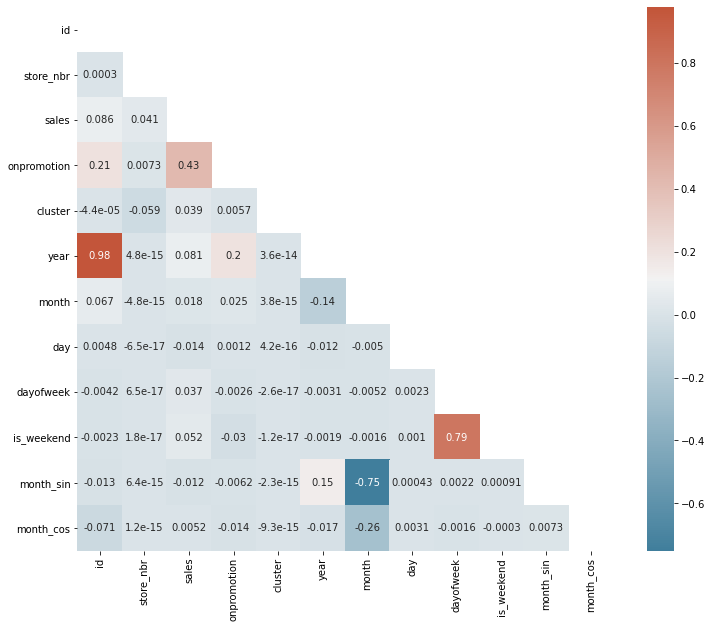

In [74]:
# Correlation between different variables
#
corr = train_stores_filtered_df.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [75]:
corr

,id,store_nbr,sales,onpromotion,cluster,year,month,day,dayofweek,is_weekend,month_sin,month_cos
id,1.000000,3.014103e-04,0.085720,0.206482,-4.370588e-05,9.777130e-01,6.671770e-02,4.788663e-03,-4.171544e-03,-2.264619e-03,-1.261021e-02,-7.117894e-02
store_nbr,0.000301,1.000000e+00,0.041266,0.007299,-5.928399e-02,4.754380e-15,-4.811814e-15,-6.461613e-17,6.498556e-17,1.786824e-17,6.352160e-15,1.230143e-15
sales,0.085720,4.126598e-02,1.000000,0.427818,3.861244e-02,8.135004e-02,1.839490e-02,-1.352699e-02,3.700848e-02,5.176410e-02,-1.233344e-02,5.219841e-03
onpromotion,0.206482,7.298552e-03,0.427818,1.000000,5.690611e-03,1.994726e-01,2.500989e-02,1.172815e-03,-2.644331e-03,-2.975365e-02,-6.242148e-03,-1.408658e-02
cluster,-0.000044,-5.928399e-02,0.038612,0.005691,1.000000e+00,3.561477e-14,3.780255e-15,4.178707e-16,-2.566248e-17,-1.214582e-17,-2.339848e-15,-9.263064e-15
year,0.977713,4.754380e-15,0.081350,0.199473,3.561477e-14,1.000000e+00,-1.434852e-01,-1.201788e-02,-3.091395e-03,-1.914171e-03,1.453451e-01,-1.746259e-02
month,0.066718,-4.811814e-15,0.018395,0.025010,3.780255e-15,-1.434852e-01,1.000000e+00,-5.036300e-03,-5.166350e-03,-1.641171e-03,-7.497473e-01,-2.567635e-01
day,0.004789,-6.461613e-17,-0.013527,0.001173,4.178707e-16,-1.201788e-02,-5.036300e-03,1.000000e+00,2.342255e-03,1.001555e-03,4.297801e-04,3.097613e-03
dayofweek,-0.004172,6.498556e-17,0.037008,-0.002644,-2.566248e-17,-3.091395e-03,-5.166350e-03,2.342255e-03,1.000000e+00,7.907832e-01,2.158814e-03,-1.596327e-03
is_weekend,-0.002265,1.786824e-17,0.051764,-0.029754,-1.214582e-17,-1.914171e-03,-1.641171e-03,1.001555e-03,7.907832e-01,1.000000e+00,9.114258e-04,-3.040046e-04


Data is now ready to train model.

## Encoding of Category Columns

In [76]:
category_columns = ['family','city','state','type','event']
train_data_encoded = pd.get_dummies(train_stores_filtered_df,columns=category_columns, drop_first=True)

In [77]:
train_stores_filtered_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'event', 'year', 'month', 'day',
       'dayofweek', 'is_weekend', 'month_sin', 'month_cos'],
      dtype='object')

In [78]:
train_stores_filtered_df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [79]:
train_data_encoded.shape

(2991978, 91)

As using Random Forest model , dont do feature scaling

In [80]:
X = train_data_encoded.loc[:, ~train_data_encoded.columns.isin(['id', 'sales','date'])]
y = train_data_encoded.loc[:,'sales'].values


## Splitting the dataset into the Training set and Test set

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [82]:
X_train.head()

,store_nbr,onpromotion,cluster,year,month,day,dayofweek,is_weekend,month_sin,month_cos,...,type_B,type_C,type_D,type_E,event_Bridge,event_Event,event_Holiday,event_Normal Day,event_Transfer,event_Work Day
1186126,4,1,9,2014,10,29,2,False,-1.000000e+00,-1.836970e-16,...,0,0,1,0,0,0,0,1,0,0
1620616,30,0,3,2015,7,1,2,False,1.224647e-16,-1.000000e+00,...,0,1,0,0,0,0,0,1,0,0
1463500,22,0,7,2015,4,4,5,True,1.000000e+00,6.123234e-17,...,0,1,0,0,0,0,0,1,0,0
2704738,49,7,11,2017,3,2,3,False,8.660254e-01,5.000000e-01,...,0,0,0,0,0,0,0,1,0,0
588556,23,0,9,2013,11,27,2,False,-8.660254e-01,5.000000e-01,...,0,0,1,0,0,0,0,1,0,0


In [83]:
y_train

array([6.540000e+02, 2.000000e+00, 0.000000e+00, ..., 1.006788e+04,
       2.800000e+01, 0.000000e+00])

In [84]:
X_test.head()

,store_nbr,onpromotion,cluster,year,month,day,dayofweek,is_weekend,month_sin,month_cos,...,type_B,type_C,type_D,type_E,event_Bridge,event_Event,event_Holiday,event_Normal Day,event_Transfer,event_Work Day
371573,34,0,6,2013,7,28,6,True,1.224647e-16,-1.000000,...,1,0,0,0,0,0,0,0,0,0
2208033,13,8,15,2016,5,27,4,False,8.660254e-01,-0.500000,...,0,1,0,0,0,1,0,0,0,0
329730,10,0,15,2013,7,5,4,False,1.224647e-16,-1.000000,...,0,1,0,0,0,0,0,1,0,0
2069120,15,0,15,2016,3,10,3,False,8.660254e-01,0.500000,...,0,1,0,0,0,0,0,1,0,0
1706664,45,7,11,2015,8,18,1,False,-5.000000e-01,-0.866025,...,0,0,0,0,0,0,0,1,0,0


In [85]:
y_test

array([   0.   , 1298.   ,    0.   , ...,   60.559,   46.   ,  141.   ])

## Training the Random Forest Model on the Training set

In [86]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [88]:
train_data_encoded.columns

Index(['id', 'date', 'store_nbr', 'sales', 'onpromotion', 'cluster', 'year',
       'month', 'day', 'dayofweek', 'is_weekend', 'month_sin', 'month_cos',
       'family_BABY CARE', 'family_BEAUTY', 'family_BEVERAGES', 'family_BOOKS',
       'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING',
       'family_DAIRY', 'family_DELI', 'family_EGGS', 'family_FROZEN FOODS',
       'family_GROCERY I', 'family_GROCERY II', 'family_HARDWARE',
       'family_HOME AND KITCHEN I', 'family_HOME AND KITCHEN II',
       'family_HOME APPLIANCES', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'cit

## Predicting the Test set results

In [89]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[   0.      0.  ]
 [1459.6  1298.  ]
 [   0.      0.  ]
 ...
 [  52.05   60.56]
 [  35.1    46.  ]
 [ 182.8   141.  ]]


Preparing the 'date' column effectively for a Random Forest model involves extracting features that the model can use to find patterns. Random Forest, being a decision-tree-based ensemble method, does not understand dates in their raw string format. You need to convert these dates into a format or features that represent meaningful information for the model. Here are some steps and strategies you can use:

1. **Parse Dates**: Ensure that the 'date' column is parsed into a datetime format if it isn't already. This can usually be done using pandas in Python with `pd.to_datetime()`.

    ```python
    import pandas as pd

    # Assuming df is your DataFrame and 'date' is the column
    df['date'] = pd.to_datetime(df['date'])
    ```

2. **Extract Time Features**: Extract parts of the date that could be relevant for your model. Common features include year, month, day, day of the week, and whether the date is a weekend or not. Here's how you could do it:

    ```python
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['date'].dt.dayofweek >= 5
    ```

3. **Consider Seasonality and Cyclic Features**: For some datasets, the time of year is important. You might need to capture seasonality or cyclic nature of the data, such as knowing that December is close to January in terms of season but far apart numerically. One way to capture this is by using sine and cosine transformations for cyclic features like months or days.

    ```python
    df['month_sin'] = np.sin((df['month']-1) * (2. * np.pi/12))
    df['month_cos'] = np.cos((df['month']-1) * (2. * np.pi/12))
    ```

4. **Engineering Holiday and Special Events**: If your data could be influenced by holidays or special events, consider adding a binary feature indicating the presence of a holiday or event. This requires an external dataset or a list of dates for the holidays.

    ```python
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

    cal = calendar()
    holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())
    df['is_holiday'] = df['date'].isin(holidays)
    ```

5. **Remove Original Date Column (if necessary)**: After extracting all relevant features, the original 'date' column may no longer be needed and can be dropped to avoid confusion.

    ```python
    df.drop('date', axis=1, inplace=True)
    ```

6. **Scaling and Normalization (Optional)**: Depending on the range of your extracted features and the rest of your dataset, you might need to scale or normalize these features. Random Forests are generally less sensitive to this, but it can be necessary for other parts of your pipeline.

Remember, the choice of features to extract from the 'date' column should be guided by domain knowledge and the specific context of your problem. It's also a good idea to experiment with different date features to see what improves your model's performance.

In [90]:
from sklearn.metrics import r2_score
r2_score(y_pred,y_test)

0.9238446033612212